In [51]:
import kagglehub
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
from tqdm import tqdm
import torch.nn as nn
from transformers import CLIPVisionModel, CLIPImageProcessor
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
print(device)

cuda


In [3]:
path = kagglehub.dataset_download("ponaekj/artifact-mini")
root_path = os.path.join(path, 'root/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1/')
print(root_path)

100%|██████████| 174M/174M [00:01<00:00, 110MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/ponaekj/artifact-mini/versions/5/root/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1/


In [4]:
real_sources = [
    "ffhq",          # Flickr-Faces-HQ
    "imagenet",      # ImageNet
    "lsun",          # LSUN Scene Understanding
    "landscape",     # Пейзажи (например, Landscape Photos)
    "metfaces",      # MetFaces
    "afhq",          # Animal Faces-HQ
    "celebahq",      # CelebA-HQ
    "coco"           # Common Objects in Context
]

In [5]:
fake_methods = {
    # 13 GANs
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "pro_gan",
    "projected_gan", "gau_gan", "star_gan", "gansformer", "generative_inpainting",
    "mat", "palette", "taming_transformer",

    # 7 Diffusion
    "ddpm", "latent_diffusion", "stable_diffusion", "vq_diffusion",
    "glide", "lama", "denoising_diffusion_gan",

    # 5 Others
    "face_synthetics", "cips", "cycle_gan", "sfhq", "diffusion_gan"
}

In [6]:
def split_dataset(root_dir, test_size=0.2, random_state=42):
    """
    Разделяет данные на train/test с сохранением структуры папок
    """
    # Создаем директории для train и test
    train_dir = os.path.join(root_dir, 'train')
    test_dir = os.path.join(root_dir, 'test')
    if os.path.exists(train_dir) or os.path.exists(test_dir):
        print("⚠️ Папки train/test уже существуют. Удалите их вручную для повторного разделения.")
        return
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Собираем все файлы с сохранением структуры

    for folder in os.listdir(root_dir):
        if folder in ['train', 'test']:  # Пропускаем уже созданные
            continue

        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        # Создаем аналогичные папки в train и test
        os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, folder), exist_ok=True)

        # Получаем все файлы и разделяем
        all_files = []
        for root, _, files in os.walk(folder_path):
            if 'train' in root.split(os.sep) or 'test' in root.split(os.sep):
                continue
            for file in files:
                if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    all_files.append(os.path.join(root, file))

        # Стратифицированное разделение
        if all_files:
            # Создаем метки для стратификации
            labels = [0 if folder in real_sources else 1 for _ in all_files]
            train_files, test_files = train_test_split(
                all_files,
                test_size=test_size,
                random_state=random_state,
                stratify=labels
            )

            # Копируем файлы
            for file in train_files:
                shutil.copy(file, os.path.join(train_dir, folder, os.path.basename(file)))
            for file in test_files:
                shutil.copy(file, os.path.join(test_dir, folder, os.path.basename(file)))

    print(f"Данные разделены: {len(os.listdir(train_dir))} классов в train, {len(os.listdir(test_dir))} в test")

# Использование
split_dataset(root_path, test_size=0.2)

Данные разделены: 33 классов в train, 33 в test


In [7]:
class ArtiFactDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        self.real_sources = real_sources  # 8 источников
        self.fake_methods = fake_methods  # 25 методов

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)

            if folder in self.real_sources:
                label_method = "real"
                is_fake = 0  # 0 для реальных изображений
            elif folder in self.fake_methods:
                label_method = folder  # Название метода генерации
                is_fake = 1  # 1 для сгенерированных изображений
            else:
                print(f"⚠️ Неизвестная папка: '{folder}'. Пропускаем...")
                continue

            # Рекурсивно собираем все изображения
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.lower().endswith((".jpg", ".png", ".jpeg")):
                        self.samples.append((
                            os.path.join(root, file),
                            label_method,  # Метка метода ("real", "stylegan3" и т.д.)
                            is_fake       # Бинарный флаг (0 или 1)
                        ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_method, is_fake = self.samples[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label_method, is_fake  # Возвращаем изображение, текстовую метку и бинарный флаг


# Пример использования
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset_train = ArtiFactDataset(root_dir=os.path.join(root_path, "train"), transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataset_test = ArtiFactDataset(root_dir=os.path.join(root_path, "test"), transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

# Проверка
for images, labels, flag in dataloader_train:
    print(f"Batch shape: {images.shape}, Labels: {labels}, ItsFake: {flag}")
    break

Batch shape: torch.Size([32, 3, 224, 224]), Labels: ('cycle_gan', 'stylegan1', 'stylegan2', 'real', 'projected_gan', 'real', 'palette', 'taming_transformer', 'palette', 'cycle_gan', 'real', 'real', 'real', 'real', 'big_gan', 'real', 'real', 'star_gan', 'face_synthetics', 'taming_transformer', 'generative_inpainting', 'sfhq', 'real', 'real', 'cycle_gan', 'real', 'real', 'stylegan1', 'real', 'diffusion_gan', 'real', 'cips'), ItsFake: tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1])


In [21]:
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPVisionModel.from_pretrained(model_name)
processor = CLIPImageProcessor.from_pretrained(model_name)

for param in clip_model.parameters():
    param.requires_grad = False

class CLIPBinaryClassifier(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model
        self.classifier = nn.Linear(clip_model.config.hidden_size, 1)  # Один выход

    def forward(self, pixel_values):
        outputs = self.clip(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output).squeeze(1)  # [batch_size]
        return logits

model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPVisionModel.from_pretrained(model_name)
processor = CLIPImageProcessor.from_pretrained(model_name)

for param in clip_model.parameters():
    param.requires_grad = False

model = CLIPBinaryClassifier(clip_model).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


for epoch in tqdm(range(10)):
    model.train()
    for pixel_values, method_names, binary_labels in dataloader_train:
        pixel_values = pixel_values.to(device)
        binary_labels = binary_labels.float().to(device)

        optimizer.zero_grad()
        logits = model(pixel_values)
        loss = criterion(logits, binary_labels)
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [04:19<00:00, 26.00s/it]


In [22]:
torch.save(model.state_dict(), 'model_weights.pth')

In [24]:
# Параметры нормализации CLIP (из CLIPProcessor)
clip_mean = [0.48145466, 0.4578275, 0.40821073]
clip_std = [0.26862954, 0.26130258, 0.27577711]

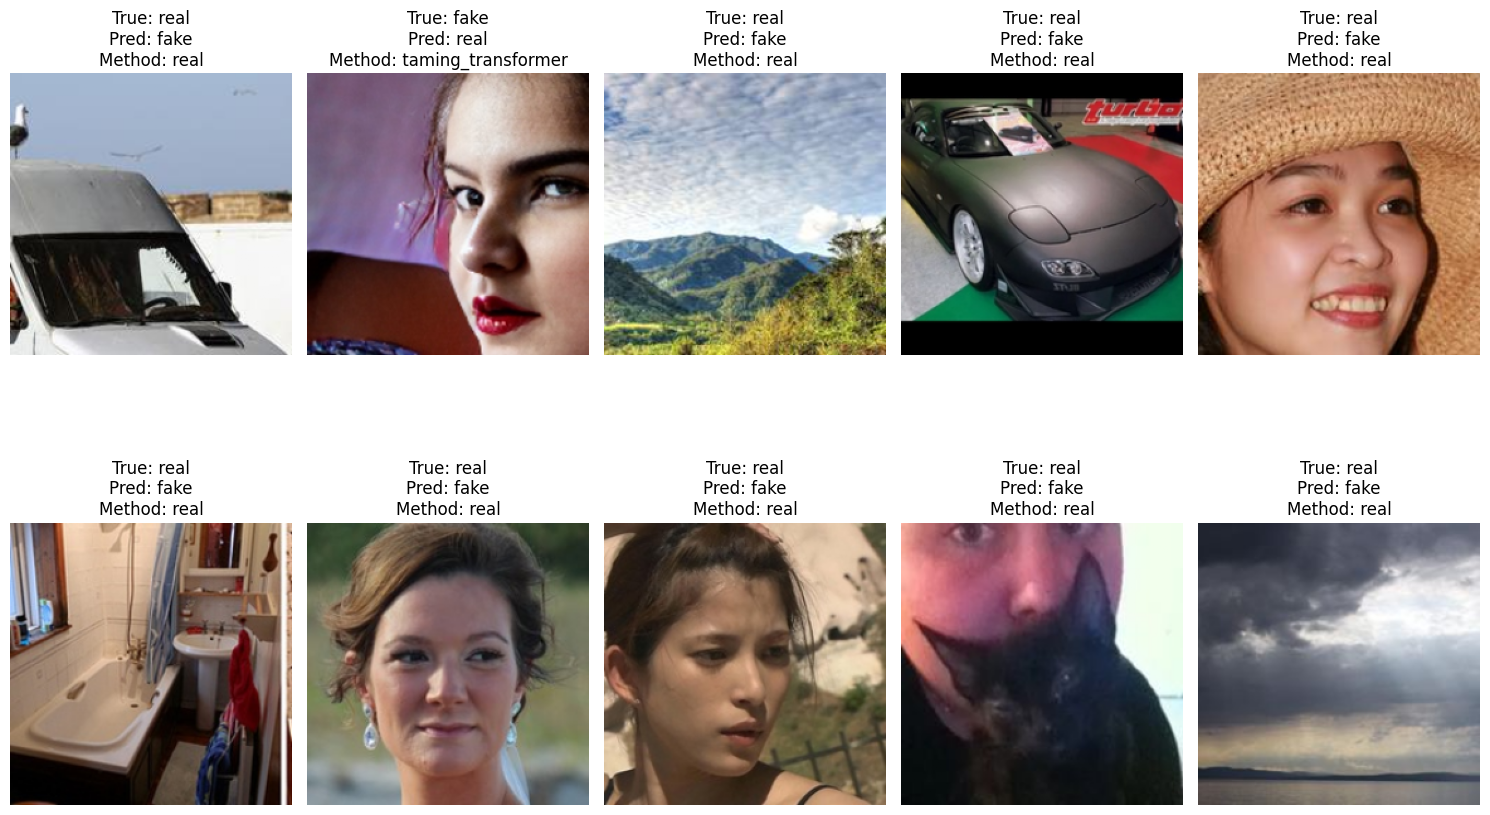

                         accuracy  precision    recall        f1   count
real                     0.332971   1.000000  0.332971  0.499592   919.0
face_synthetics          1.000000   1.000000  1.000000  1.000000    53.0
stylegan3                0.814815   1.000000  0.814815  0.897959    54.0
star_gan                 0.924528   1.000000  0.924528  0.960784    53.0
cips                     0.962264   1.000000  0.962264  0.980769    53.0
gansformer               0.943396   1.000000  0.943396  0.970874    53.0
ddpm                     1.000000   1.000000  1.000000  1.000000     6.0
generative_inpainting    0.867925   1.000000  0.867925  0.929293    53.0
projected_gan            0.886792   1.000000  0.886792  0.940000    53.0
lama                     0.944444   1.000000  0.944444  0.971429    54.0
glide                    0.943396   1.000000  0.943396  0.970874    53.0
palette                  0.622642   1.000000  0.622642  0.767442    53.0
sfhq                     0.943396   1.000000  0.943

In [69]:
def evaluate_model(model, dataloader, device, class_names, threshold=0.5):
    model.eval()
    all_preds = []
    all_true = []
    all_methods = []
    all_probs = []
    error_samples = []

    with torch.no_grad():
        for images, methods, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).long().squeeze()
            all_probs.extend(outputs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
            all_methods.extend(methods)

            for i in range(len(preds)):
                if preds[i] != labels[i]:
                    error_samples.append((
                        images[i].cpu(),
                        methods[i],
                        preds[i].item(),
                        labels[i].item()
                    ))

    all_true = np.array(all_true)
    all_preds = np.array(all_preds)
    all_methods = np.array(all_methods)
    all_probs = np.array(all_probs)

    overall_metrics = [
        accuracy_score(all_true, all_preds),
        precision_score(all_true, all_preds, average='macro'),
        recall_score(all_true, all_preds, average='macro'),
        f1_score(all_true, all_preds, average='macro'),
        len(all_true)
    ]

    # Метрики по классам
    class_metrics = {}
    for class_name in class_names:
        class_idx = class_names.index(class_name)
        mask = (all_methods == class_name)
        if sum(mask) > 0:  # Если класс присутствует в тестовых данных
            if class_name == 'real':
                class_metrics[class_name] = {
                    'accuracy': accuracy_score(all_true[mask], all_preds[mask]),
                    'precision': precision_score(all_true[mask], all_preds[mask], average='binary', pos_label=0),
                    'recall': recall_score(all_true[mask], all_preds[mask], average='binary', pos_label=0),
                    'f1': f1_score(all_true[mask], all_preds[mask], average='binary', pos_label=0),
                    'count': sum(mask)
                }
            else:
                class_metrics[class_name] = {
                    'accuracy': accuracy_score(all_true[mask], all_preds[mask]),
                    'precision': precision_score(all_true[mask], all_preds[mask], average='binary'),
                    'recall': recall_score(all_true[mask], all_preds[mask], average='binary'),
                    'f1': f1_score(all_true[mask], all_preds[mask], average='binary'),
                    'count': sum(mask)
                }

    # Визуализация ошибок
    plot_errors(error_samples)
    df = pd.DataFrame(class_metrics).T
    df.loc['overall'] = overall_metrics
    return all_probs, all_true, df

def plot_errors(error_samples, num_samples=10):
    class_names = ['real', 'fake']
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(error_samples))):
        img, method, pred, true = error_samples[i]
        img = img.permute(1, 2, 0).numpy()
        if img.shape[2] == 3:  # RGB
            img = img  # Денормализация
        else:  # Grayscale
            img = img.squeeze()

        plt.subplot(2, 5, i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}\nMethod: {method}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


class_names = ['real'] + list(dataset_train.fake_methods)  # ['real', 'stylegan3', 'ddpm', ...]
model = CLIPBinaryClassifier(clip_model).to(device)
model.load_state_dict(torch.load('model_weights.pth'))
predicted_probs, true_labels, class_metrics = evaluate_model(model, dataloader_test, device, class_names)
print(class_metrics)

Ну тут определенно видно жесткий дисбаланс и что-то с этим надо делать: Видно, что на реальных данных все очень плохо, короче, подберем трэшхолд.

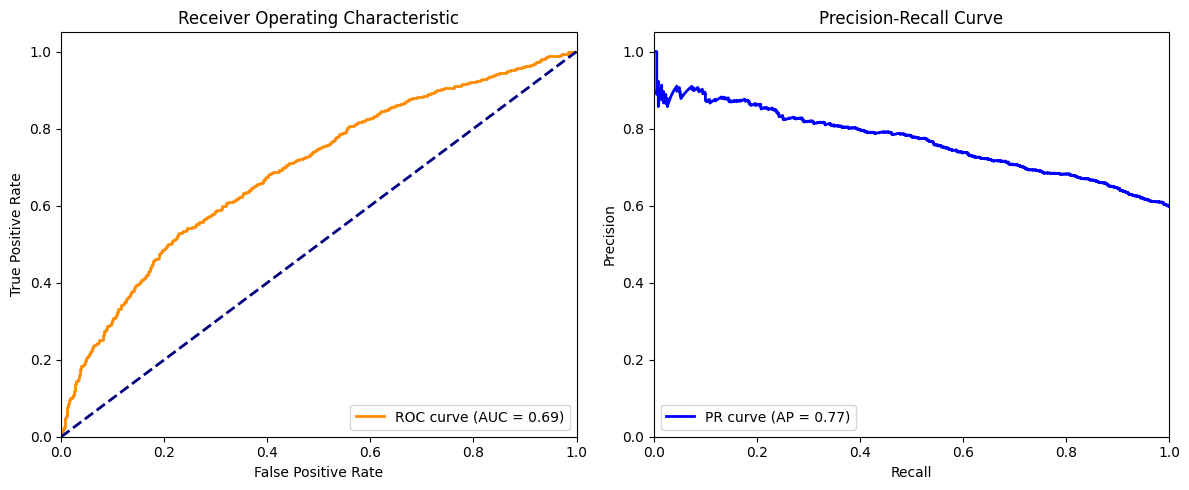

In [70]:
def plot_curves(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []

    # Собираем предсказания и истинные метки
    with torch.no_grad():
        for images, _, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze()

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Преобразуем в numpy массивы
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # ROC-AUC кривая
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall кривая
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    avg_precision = average_precision_score(all_labels, all_probs)

    # Создаем графики
    plt.figure(figsize=(12, 5))

    # ROC-AUC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Пример использования
plot_curves(model, dataloader_test, device)

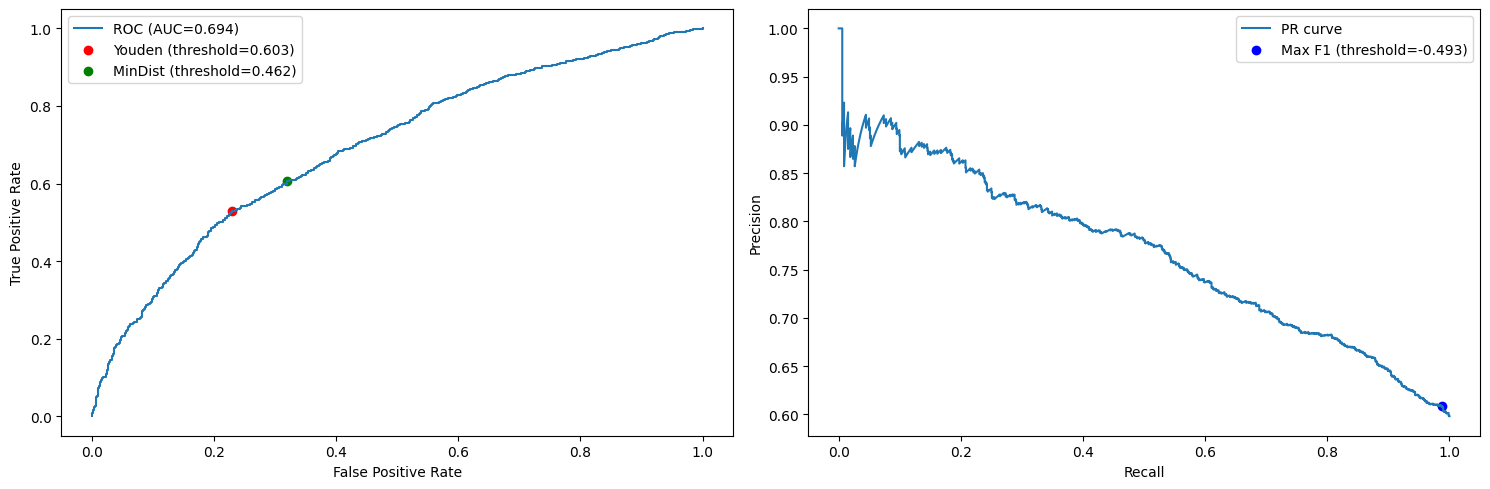

Оптимальные пороги: {'youden': np.float32(0.60320085), 'f1_max': np.float32(-0.4927652), 'roc_dist': np.float32(0.46204245)}


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

def find_optimal_threshold(true_labels, predicted_probs):
    # ROC анализ
    fpr, tpr, roc_thresholds = roc_curve(true_labels, predicted_probs)
    youden_idx = np.argmax(tpr - fpr)

    # Precision-Recall анализ
    precision, recall, pr_thresholds = precision_recall_curve(true_labels, predicted_probs)
    f1_scores = 2*(precision*recall)/(precision+recall+1e-9)
    f1_idx = np.argmax(f1_scores)

    # Метод расстояния
    distances = np.sqrt(fpr**2 + (1-tpr)**2)
    dist_idx = np.argmin(distances)

    # Собираем результаты
    thresholds = {
        'youden': roc_thresholds[youden_idx],
        'f1_max': pr_thresholds[f1_idx],
        'roc_dist': roc_thresholds[dist_idx]
    }

    # Визуализация
    plt.figure(figsize=(15, 5))

    # ROC кривая
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC (AUC={auc(fpr, tpr):.3f})')
    plt.scatter(fpr[youden_idx], tpr[youden_idx], c='red',
                label=f'Youden (threshold={thresholds["youden"]:.3f})')
    plt.scatter(fpr[dist_idx], tpr[dist_idx], c='green',
                label=f'MinDist (threshold={thresholds["roc_dist"]:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # Precision-Recall кривая
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='PR curve')
    plt.scatter(recall[f1_idx], precision[f1_idx], c='blue',
                label=f'Max F1 (threshold={thresholds["f1_max"]:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return thresholds

optimal_thresholds = find_optimal_threshold(true_labels, predicted_probs)
print("Оптимальные пороги:", optimal_thresholds)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


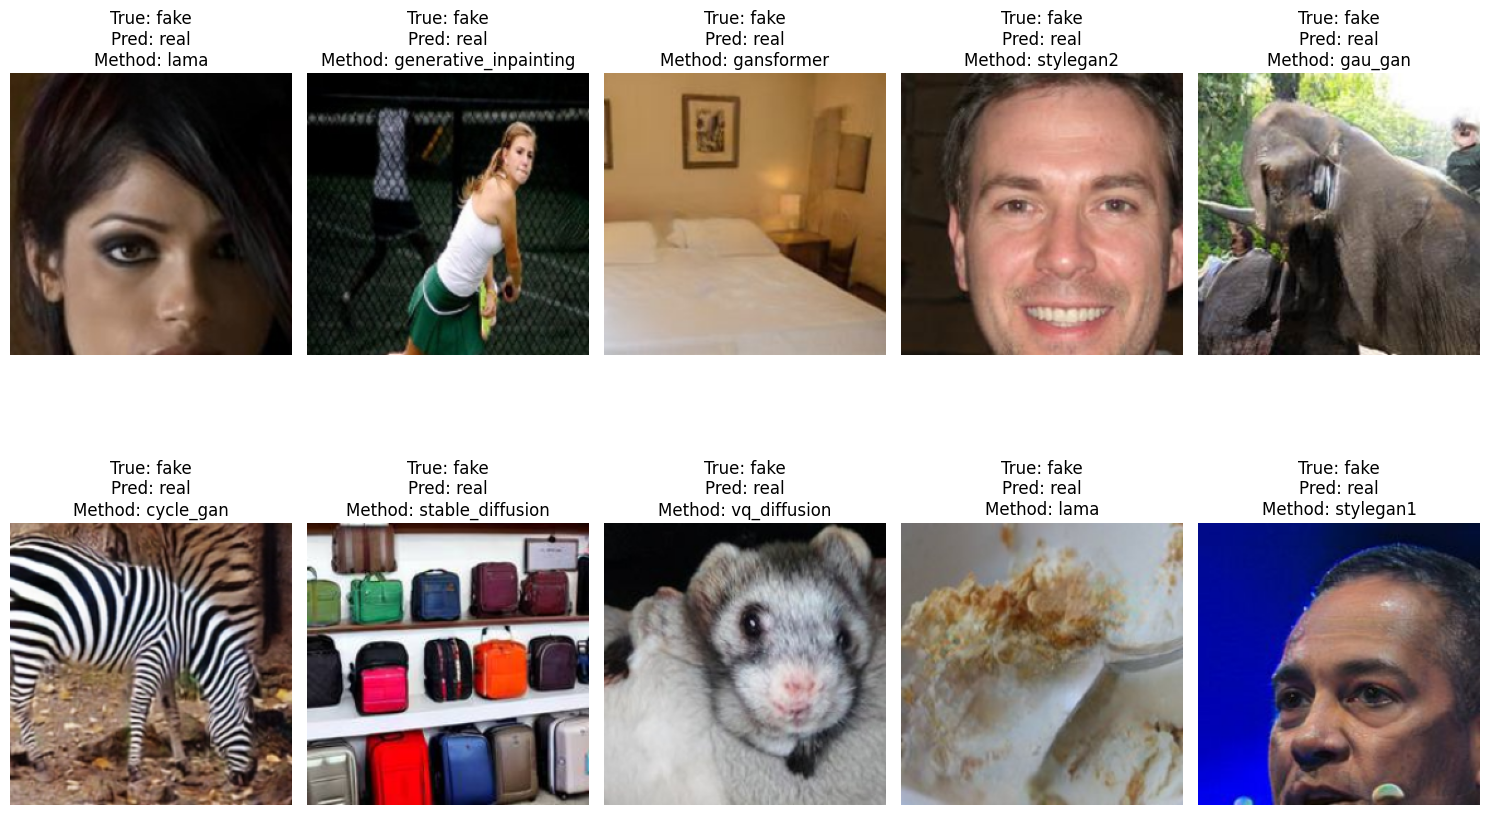

                         accuracy  precision    recall        f1   count
real                     0.877040   0.000000  0.000000  0.000000   919.0
face_synthetics          0.886792   1.000000  0.886792  0.940000    53.0
stylegan3                0.092593   1.000000  0.092593  0.169492    54.0
star_gan                 0.264151   1.000000  0.264151  0.417910    53.0
cips                     0.528302   1.000000  0.528302  0.691358    53.0
gansformer               0.339623   1.000000  0.339623  0.507042    53.0
ddpm                     0.500000   1.000000  0.500000  0.666667     6.0
generative_inpainting    0.301887   1.000000  0.301887  0.463768    53.0
projected_gan            0.622642   1.000000  0.622642  0.767442    53.0
lama                     0.277778   1.000000  0.277778  0.434783    54.0
glide                    0.471698   1.000000  0.471698  0.641026    53.0
palette                  0.075472   1.000000  0.075472  0.140351    53.0
sfhq                     0.490566   1.000000  0.490

In [59]:
predicted_probs, true_labels, class_metrics = evaluate_model(model, dataloader_test, device, class_names, 0.7)
print(class_metrics)

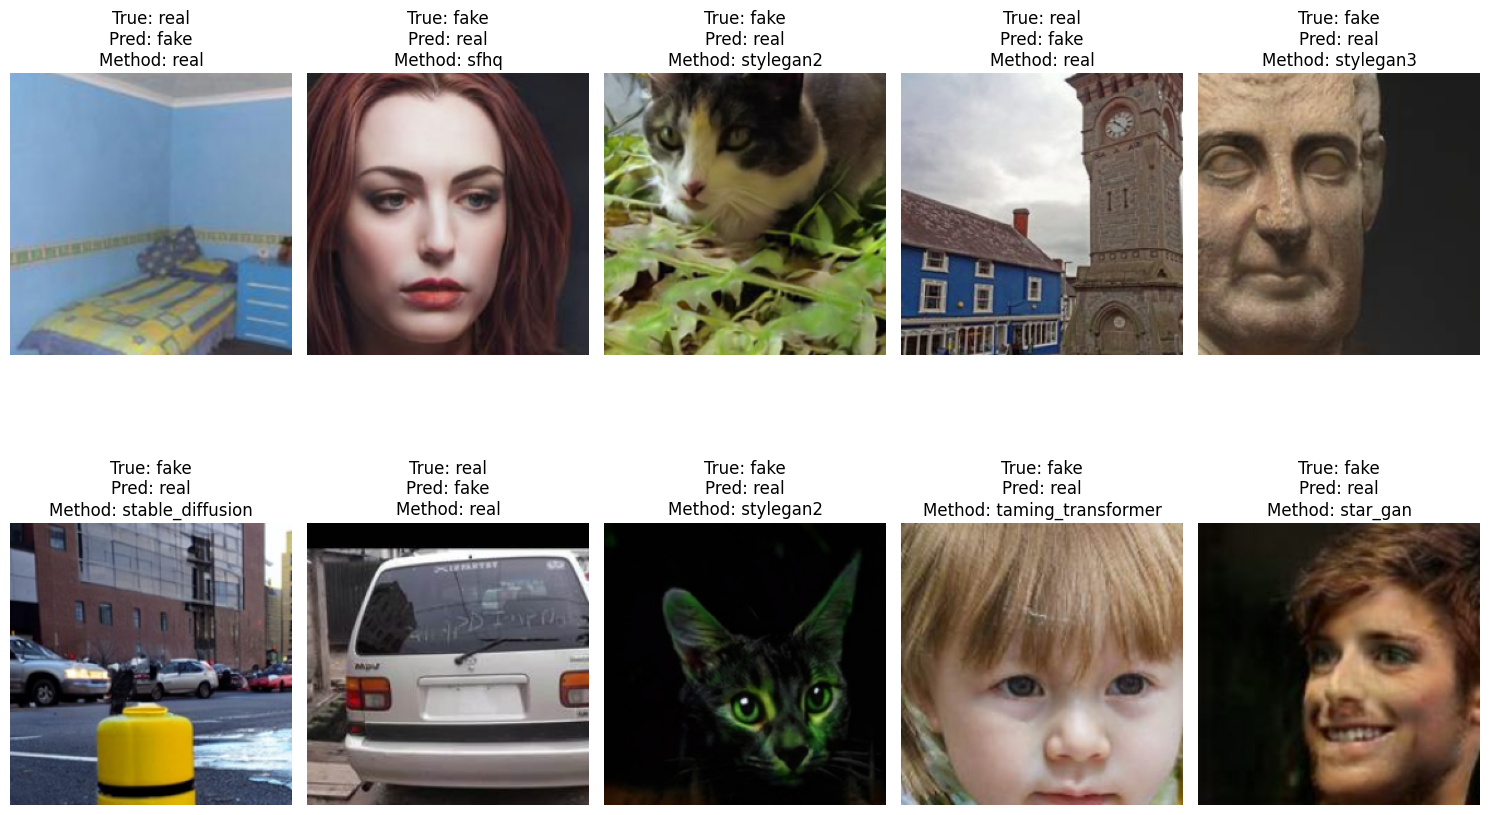

                         accuracy  precision    recall        f1   count
real                     0.646355   1.000000  0.646355  0.785195   919.0
face_synthetics          1.000000   1.000000  1.000000  1.000000    53.0
stylegan3                0.407407   1.000000  0.407407  0.578947    54.0
star_gan                 0.679245   1.000000  0.679245  0.808989    53.0
cips                     0.811321   1.000000  0.811321  0.895833    53.0
gansformer               0.641509   1.000000  0.641509  0.781609    53.0
ddpm                     1.000000   1.000000  1.000000  1.000000     6.0
generative_inpainting    0.603774   1.000000  0.603774  0.752941    53.0
projected_gan            0.830189   1.000000  0.830189  0.907216    53.0
lama                     0.759259   1.000000  0.759259  0.863158    54.0
glide                    0.754717   1.000000  0.754717  0.860215    53.0
palette                  0.264151   1.000000  0.264151  0.417910    53.0
sfhq                     0.735849   1.000000  0.735

In [72]:
_, _, class_metrics = evaluate_model(model, dataloader_test, device, class_names, optimal_thresholds['youden'])
print(class_metrics)